#side notes
fig = s.plot()
fig = plt.figure()
fig.set_size_inches(15, 8)
df[['亚马逊市场容量']].diff().plot(figsize=(20,10), linewidth=5,fontsize=20)
df[['亚马逊市场容量']].rolling(12).mean().plot(figsize=(20,15),linewidth=5,fontsize=20)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine
from sklearn import datasets , linear_model
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
from datetime import datetime
%matplotlib inline
sns.set()
localEngine= create_engine('mysql+pymysql://chencheng:iKWz@4*7W55@10.1.1.202:3306')
localCon= localEngine.connect()

sql = '''
    select category,category_id,amazon_market_share_money,DATE_FORMAT(analyzed_at, '%Y-%m-%d') as date
    from amazon_analysis.category_report report
    right join amazon_analysis.category_report_result_content result on report.result_id = result.id
    where category_id = '3733671'
    '''
df = pd.read_sql(sql,localEngine)
df.drop_duplicates(['date'],inplace=True)
df.rename(columns={'amazon_market_share_money':'AMV'},inplace=True)
df=df.sort_values(by='date',ascending=True)
maxdate=df[df['AMV']==df['AMV'].max()]['date'].values[0]
df.set_index('date',inplace=True)
s=sm.tsa.seasonal_decompose(df.AMV,period=30)

s.trend.loc[s.trend[s.trend.notna()].index.max()]-s.trend.loc[s.trend[s.trend.notna()].index.min()]>0

判断绝对变化，平滑后数据的最右端和最左端数值比较，即去除异常点后，判断如今的市场容量比有记录的第一天比较是大是小

最近的日子 :2021-02-21

最初的日子 : 2020-10-02

2021-02-21 的市场容量小于 2020-10-02
绝对变化：下降

<AxesSubplot:xlabel='date'>

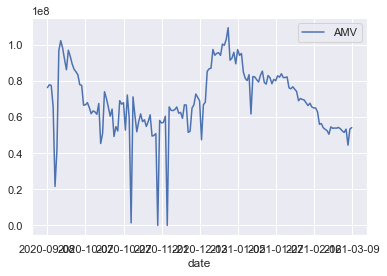

In [12]:
df.plot()
#原始数据走势图

<AxesSubplot:xlabel='date'>

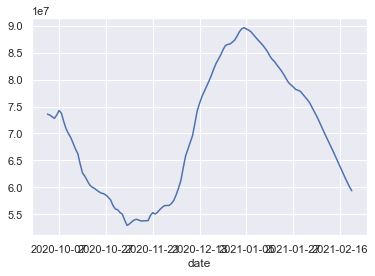

In [4]:
#平滑后数据
s.trend.plot()

In [ ]:
转化数据，将离散日期转化为连续天数
使用回归模型，计算一阶导，判断全局走向

In [5]:
X=s.trend[s.trend.notna()].index
y=s.trend[s.trend.notna()].values
#转化数据，将离散日期转化为连续天数
trans=[]
for i in X:
    trans.append((datetime.strptime(i,"%Y-%m-%d")-datetime.strptime(X.min(),"%Y-%m-%d")).days)
X_train , X_test , y_train , y_test = train_test_split(np.array(trans).reshape(-1,1),y,test_size=0.2,random_state=42)
#导入模型，模型参数默认
LR = linear_model.LinearRegression()
#训练模型
LR.fit(X_train,y_train)
LR.coef_ #全局走向,即整体是否上升。
LR.coef_ > 0

array([ True])

In [6]:
#计算局部最高/最低点
s.trend[s.trend.values==s.trend[s.trend.notna()].values.max()].index.values[0]
#计算局部最高/最低点后，市场的走势。
recentX=s.trend[s.trend.notna().index>s.trend[s.trend.values==s.trend[s.trend.notna()].values.max()].index.values[0]][
    s.trend[s.trend.notna().index>s.trend[s.trend.values==s.trend[s.trend.notna()].values.max()].index.values[0]].values>0].index
recentY=s.trend[s.trend.notna().index>s.trend[s.trend.values==s.trend[s.trend.notna()].values.max()].index.values[0]][
    s.trend[s.trend.notna().index>s.trend[s.trend.values==s.trend[s.trend.notna()].values.max()].index.values[0]].values>0].values
#数据转换
recentTrans=[]
for i in recentX:
    recentTrans.append((datetime.strptime(i,"%Y-%m-%d")-datetime.strptime(X.min(),"%Y-%m-%d")).days)
X_train , X_test , y_train , y_test = train_test_split(np.array(recentTrans).reshape(-1,1),recentY,test_size=0.2,random_state=42)

#导入模型，模型参数默认
LR = linear_model.LinearRegression()
#训练模型
LR.fit(X_train,y_train)
#局部走向,即最近市场容量是否上升。
LR.coef_>0

array([False])